<a href="https://colab.research.google.com/github/btran30/cs584/blob/brenda/Densenet201_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DenseNet 201 Analysis

## Library Import

In [1]:
import tensorflow 
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
import time

from tensorflow.keras.datasets import cifar100, cifar10
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization,Activation,Flatten,MaxPooling2D,Dropout
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

print("Tensorflow-version:", tensorflow.__version__)

Tensorflow-version: 2.3.0


## Load and preprocess Data from Keras

In [2]:
def preprocess_data(num_classes):

    if num_classes == 100:
        (x_train, y_train), (x_test, y_test) = cifar100.load_data()
    else :
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        
    x_train = tensorflow.keras.applications.densenet.preprocess_input(x_train)
    x_test = tensorflow.keras.applications.densenet.preprocess_input(x_test)
    y_train = tensorflow.keras.utils.to_categorical(y_train)
    y_test = tensorflow.keras.utils.to_categorical(y_test)
       
    print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
    print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
    return (x_train, y_train), (x_test, y_test) 

## DenseNet 201 Model

We utilize ImageDataGenerator to augment our input data.  This should help us avoid overfitting.

In [4]:
def fit_model(num_classes, x_train, y_train, x_test, y_test):
    densenet_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in densenet_model.layers:
      if isinstance(layer, BatchNormalization):
        layer.trainable = True  # update the weight
      else:
        layer.trainable = False
        
    model = Sequential()
    model.add(UpSampling2D(size=(7,7)))
    model.add(densenet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(.25))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy'])

    datagen = ImageDataGenerator(rotation_range=8,
                             shear_range=0.2, 
                             zoom_range=0.2,
                             channel_shift_range=0.05, 
                             horizontal_flip=True)
    datagen.fit(x_train)
    # Fits-the-model
    batch_size = 64
    epochs = 10
    anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1, min_lr=1e-3)
    t=time.time()
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
               steps_per_epoch=x_train.shape[0] // batch_size,
               epochs=epochs,
               verbose=1,
               callbacks=[anne],
               validation_data=(x_test, y_test))
    print('Training time: %s' % (time.time() -t))
    model.save('Densenet201_cifar'+str(num_classes)+'.h5')
    return history, model

In [ ]:
def summarize_diagnostics(num_classes, history):
    cifar = 'CIFAR'+str(num_classes)
    plt.subplots_adjust(hspace=0.7)
    # plot loss
    plt.subplot(211)
    plt.title(cifar + ' Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    
    # plot accuracy
    plt.subplot(212)
    plt.title(cifar + ' Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    
    # save plot to file
    #filename = "DenseNet201_Pretrained"
    #plt.savefig(filename + '_plot.png')
    
    return history


In [ ]:
def predict(model, x_test, y_test):
    ypred = model.predict(x_test)

    total = 0
    accurate = 0
    accurateindex = []
    wrongindex = []

    for i in range(len(ypred)):
        if np.argmax(ypred[i]) == np.argmax(y_test[i]):
            accurate += 1
            accurateindex.append(i)
        else:
            wrongindex.append(i)

        total += 1
    
    print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
    print('Accuracy:', round(accurate/total*100, 3), '%')
    return ypred

### Run with CIFAR100

Train: X=(50000, 32, 32, 3), y=(50000, 100)
Test: X=(10000, 32, 32, 3), y=(10000, 100)
Epoch 1/20
390/390 [==============================] - 55s 140ms/step - loss: 3.4578 - accuracy: 0.2266 - top_k_categorical_accuracy: 0.4550 - val_loss: 2.9230 - val_accuracy: 0.3106 - val_top_k_categorical_accuracy: 0.5992
Epoch 2/20
390/390 [==============================] - 48s 122ms/step - loss: 2.1764 - accuracy: 0.4446 - top_k_categorical_accuracy: 0.7504 - val_loss: 2.0832 - val_accuracy: 0.4549 - val_top_k_categorical_accuracy: 0.7548
Epoch 3/20
390/390 [==============================] - 48s 123ms/step - loss: 1.7428 - accuracy: 0.5339 - top_k_categorical_accuracy: 0.8260 - val_loss: 1.7707 - val_accuracy: 0.5190 - val_top_k_categorical_accuracy: 0.8134
Epoch 4/20
390/390 [==============================] - 48s 122ms/step - loss: 1.4940 - accuracy: 0.5895 - top_k_categorical_accuracy: 0.8650 - val_loss: 1.6784 - val_accuracy: 0.5416 - val_top_k_categorical_accuracy: 0.8284
Epoch 5/20
390/390 [=

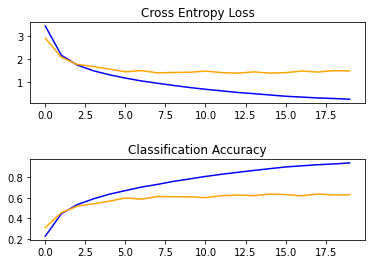

In [ ]:
num_classes = 100
(x_train, y_train), (x_test, y_test) = preprocess_data(num_classes)
history, model = fit_model(num_classes, x_train, y_train,x_test, y_test)
print('\n\n')
summarize_diagnostics(num_classes, history)
print('\n')
predict(model, x_test, y_test)

### Run with CIFAR10

In [ ]:
num_classes = 10
(x_train, y_train), (x_test, y_test) = preprocess_data(num_classes)
history, model = fit_model(num_classes, x_train, y_train,x_test, y_test)
print('\n\n')
summarize_diagnostics(num_classes, history)
print('\n')
predict(model, x_test, y_test)

Train: X=(50000, 32, 32, 3), y=(50000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


NameError: name 'fit_model' is not defined